In [5]:
sub = '9'
run = '1'
TASK = 'expectations'

# import numpy as np
# import os.path as op
# import os
# import sys

# cwd = os.getcwd()
# sys.path.append(cwd)
# print(sys.path)

# from pprint import pformat
# import argparse
# # EEG utilities
# import mne
# from mne.preprocessing import ICA, create_eog_epochs
# from pyprep.prep_pipeline import PrepPipeline
# from autoreject import get_rejection_threshold, validation_curve
# # BIDS utilities
# from mne_bids import BIDSPath, read_raw_bids
# from util.io.bids import DataSink

# # constants
# BIDS_ROOT = '../data/bids'
# DERIV_ROOT = op.join(BIDS_ROOT, 'derivatives')
# ERP_PASSBAND = (0.1, 40)
# TASK = 'expectations'
# TMIN = -0.2
# TMAX = 0.5

# '''
# Parameters
# ----------
# sub : str
#     Subject ID as in BIDS dataset
# '''
# print('----------------- load data ------------------')
# bids_path = BIDSPath(
#     root = BIDS_ROOT,
#     subject = sub,
#     task = TASK,
#     run = run,
#     datatype = 'eeg'
#     )
# print(bids_path)
# raw = read_raw_bids(bids_path, verbose = False)

raw.info['sfreq'] == 10000

True

In [ ]:
sub = '13'
run = '1'
TASK = 'expectations'

import numpy as np
import os.path as op
import os
import sys

cwd = os.getcwd()
sys.path.append(cwd)
print(sys.path)

from pprint import pformat
import argparse
# EEG utilities
import mne
from mne.preprocessing import ICA, create_eog_epochs
from pyprep.prep_pipeline import PrepPipeline
from autoreject import get_rejection_threshold, validation_curve
# BIDS utilities
from mne_bids import BIDSPath, read_raw_bids
from util.io.bids import DataSink

# constants
BIDS_ROOT = '../data/bids'
DERIV_ROOT = op.join(BIDS_ROOT, 'derivatives')
ERP_PASSBAND = (0.1, 40)
TASK = 'expectations'
TMIN = -0.2
TMAX = 0.5

'''
Parameters
----------
sub : str
    Subject ID as in BIDS dataset
'''
print('----------------- load data ------------------')
bids_path = BIDSPath(
    root = BIDS_ROOT,
    subject = sub,
    task = TASK,
    run = run,
    datatype = 'eeg'
    )
print(bids_path)
raw = read_raw_bids(bids_path, verbose = False)
events, event_ids = mne.events_from_annotations(raw)

print('----------------- re-reference eye electrodes to become bipolar EOG ------------------')
raw.load_data()
def reref(dat):
    dat[0,:] = (dat[1,:] - dat[0,:])
    return dat
raw = raw.apply_function(
    reref,
    picks = ['leog', 'Fp2'],
    channel_wise = False
)
raw = raw.apply_function(
    reref,
    picks = ['reog', 'Fp1'],
    channel_wise = False
)
raw = raw.set_channel_types({'leog': 'eog', 'reog': 'eog'})

print('----------------- run PREP pipeline ------------------') # notch, exclude bad chans, and re-reference
raw.load_data()
np.random.seed(int(sub))
lf = raw.info['line_freq']
prep_params = {
    "ref_chs": "eeg",
    "reref_chs": "eeg",
    "line_freqs": np.arange(lf, ERP_PASSBAND[1], lf)
}
prep = PrepPipeline(
    raw,
    prep_params,
    raw.get_montage(),
    ransac = False,
    random_state = int(sub)
    )
prep.fit()

print('----------------- Extract data from PREP ------------------')
prep_eeg = prep.raw_eeg # get EEG channels from PREP
prep_non_eeg = prep.raw_non_eeg # get non-EEG channels from PREP
raw_data = np.concatenate((prep_eeg.get_data(), prep_non_eeg.get_data())) # combine data from the two

# Create info object for post-PREP data
print('Create info object for post-PREP data')
new_ch_names = prep_eeg.info['ch_names'] + prep_non_eeg.info['ch_names']
raw = raw.reorder_channels(new_ch_names) # modify the channel names on the original raw data
raw_info = raw.info # use the modified info from the original raw data object
 
# Combine post-prep data and new info
print('Create new raw object')
raw = mne.io.RawArray(raw_data, raw_info) # replace original raw object

print('----------------- Filter ------------------') 
raw = raw.filter(*ERP_PASSBAND)

## now prepare non-epoched data for ERP analysis
# identify bad ICs on weakly highpassed data
print('----------------- Epoch data for ERP analysis ------------------')
epochs = mne.Epochs(
    raw,
    events, # same events as FFR epochs
    tmin = TMIN,
    tmax = TMAX, # only prestim
    event_id = event_ids,
    baseline = None,
    preload = True
)

print('----------------- Downsample ------------------') 
epochs = epochs.resample(1000) # resample after epoching to avoid adding jitter to event triggers

print('----------------- Run ICA ------------------')
ica = ICA(n_components = 15, random_state = 0)
ica.fit(epochs, picks = ['eeg', 'eog'])

print('----------------- Apply ICA ------------------')
eog_indices, eog_scores = ica.find_bads_eog(epochs, threshold = 1.96)
ica.exclude = eog_indices
ica.apply(epochs) # transforms in place 

if ica.exclude: # if we found any bad components
    fig_ica_removed = ica.plot_components(ica.exclude)

# Keep only midline channels
#epochs = epochs.pick_channels(ch_names = ['Fz', 'FCz', 'Cz', 'CPz', 'Pz'])

print('----------------- Baseline correct ------------------')
epochs = epochs.apply_baseline((TMIN, 0.))

print('----------------- Reject bad trials ------------------')
thres = get_rejection_threshold(epochs)
print(thres)
epochs.drop_bad(reject = thres)

print('----------------- Save ------------------')
sink = DataSink(DERIV_ROOT, 'erp')
erp_fpath = sink.get_path(
    subject = sub,
    task = TASK,
    run = run,
    desc = 'forERP',
    suffix = 'epo',
    extension = 'fif.gz'
)
print(f'Saving epochs for ERP analysis to: {erp_fpath}')
epochs.save(erp_fpath, overwrite = True)

print('----------------- generate a report ------------------')
report = mne.Report(verbose = True)
report.parse_folder(op.dirname(erp_fpath), pattern = '*epo.fif.gz', render_bem = False)
if ica.exclude:
    fig_ica_removed = ica.plot_components(ica.exclude, show = False)
    report.add_figure(
        fig_ica_removed,
        title = 'Removed ICA Components',
        section = 'ICA'
    )
bads = prep.noisy_channels_original
html_lines = []
for line in pformat(bads).splitlines():
    html_lines.append('<br/>%s' % line)
html = '\n'.join(html_lines)
report.add_html(html, title = 'Interpolated Channels', section = 'channels')
report.add_html(epochs.info._repr_html_(), title = 'Epochs Info (FFR)', section = 'info')
report.add_html(epochs.info._repr_html_(), title = 'Epochs Info (ERP)', section = 'info')
report.save(op.join(sink.deriv_root, 'sub-%s.html'%sub), overwrite = True)



['/project/hcn1/.conda/envs/mne/lib/python311.zip', '/project/hcn1/.conda/envs/mne/lib/python3.11', '/project/hcn1/.conda/envs/mne/lib/python3.11/lib-dynload', '', '/project/hcn1/.conda/envs/mne/lib/python3.11/site-packages', '/project/hcn1/Letty/expectations-ffr/analysis']
----------------- load data ------------------
../data/bids/sub-13/eeg/sub-13_task-expectations_run-1_eeg.vhdr
Used Annotations descriptions: ['11', '12', '13', '21', '22', '23', '31', '32', '33', '41', '42', '43', '51', '52', '53', '61', '62', '63']
----------------- re-reference eye electrodes to become bipolar EOG ------------------
Reading 0 ... 21003099  =      0.000 ...  4200.620 secs...


/scratch/local/jobs/21246077/ipykernel_1948162/217151765.py:48: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog']
  raw = read_raw_bids(bids_path, verbose = False)
/scratch/local/jobs/21246077/ipykernel_1948162/217151765.py:48: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['leog', 'reog']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)
/scratch/local/jobs/21246077/ipykernel_1948162/217151765.py:66: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw = raw.set_channel_types({'leog': 'eog', 'reog': 'eog'})


----------------- run PREP pipeline ------------------
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


['/project/hcn1/.conda/envs/mne/lib/python311.zip', '/project/hcn1/.conda/envs/mne/lib/python3.11', '/project/hcn1/.conda/envs/mne/lib/python3.11/lib-dynload', '', '/project/hcn1/.conda/envs/mne/lib/python3.11/site-packages', '/project2/hcn1/expectations-ffr/analysis', '/project2/hcn1/expectations-ffr/analysis']
----------------- load data ------------------
../data/bids/sub-13/eeg/sub-13_task-expectations_run-1_eeg.vhdr
Used Annotations descriptions: ['11', '12', '13', '21', '22', '23', '31', '32', '33', '41', '42', '43', '51', '52', '53', '61', '62', '63']


/scratch/local/jobs/20162050/ipykernel_3587220/4213796720.py:48: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Aux']
  raw = read_raw_bids(bids_path, verbose = False)
/scratch/local/jobs/20162050/ipykernel_3587220/4213796720.py:48: RuntimeWarning: Not setting positions of 3 misc/stim channels found in montage:
['leog', 'reog', 'Aux']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


----------------- re-reference eye electrodes to become bipolar EOG ------------------
Reading 0 ... 21003099  =      0.000 ...  4200.620 secs...


/scratch/local/jobs/20162050/ipykernel_3587220/4213796720.py:66: RuntimeWarning: The unit for channel(s) leog, reog has changed from NA to V.
  raw = raw.set_channel_types({'leog': 'eog', 'reog': 'eog'})


----------------- Filter ------------------
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165001 samples (33.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   18.7s


----------------- Epoch data for ERP analysis ------------------
Not setting metadata
4775 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4775 events and 3001 original time points ...
0 bad epochs dropped
----------------- Downsample ------------------
----------------- Run ICA ------------------
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 38.9s.
----------------- Apply ICA ------------------
Using EOG channels: leog, reog
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


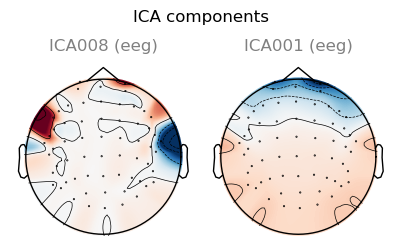

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
----------------- Baseline correct ------------------
Applying baseline correction (mode: mean)
----------------- Reject bad trials ------------------
Estimating rejection dictionary for eeg


/scratch/local/jobs/20162050/ipykernel_3587220/4213796720.py:133: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs = epochs.pick_channels(ch_names = ['Fz', 'FCz', 'Cz', 'CPz', 'Pz']) # Problem step


{'eeg': 7.42998896886051e-05}
0 bad epochs dropped
----------------- Save ------------------
Saving epochs for ERP analysis to: ../data/bids/derivatives/erp/sub-13/sub-13_task-expectations_run-1_desc-forERP_epo.fif.gz


/project2/hcn1/expectations-ffr/analysis/util/io/bids.py:27: FutureWarning: extension should start with a period ".", but got: "fif.gz". Prepending "." to form: ".fif.gz". This will raise an exception starting with MNE-BIDS 0.12.
  path = BIDSPath(


----------------- generate a report ------------------
Embedding : jquery-3.6.0.min.js
Embedding : bootstrap.bundle.min.js
Embedding : bootstrap.min.css
Embedding : bootstrap-table/bootstrap-table.min.js
Embedding : bootstrap-table/bootstrap-table.min.css
Embedding : bootstrap-table/bootstrap-table-copy-rows.min.js
Embedding : bootstrap-table/bootstrap-table-export.min.js
Embedding : bootstrap-table/tableExport.min.js
Embedding : bootstrap-icons/bootstrap-icons.mne.min.css
Embedding : highlightjs/highlight.min.js
Embedding : highlightjs/atom-one-dark-reasonable.min.css
Iterating over 1 potential files (this may take some 
Rendering : /project2/hcn1/expectations-ffr/data/bids/derivatives/erp/sub-13/sub-13_task-expectations_run-1_desc-forERP_epo.fif.gz
Reading /project2/hcn1/expectations-ffr/data/bids/derivatives/erp/sub-13/sub-13_task-expectations_run-1_desc-forERP_epo.fif.gz ...
    Found the data of interest:
        t =    -200.00 ...     399.00 ms
        0 CTF compensation matrices

/project/hcn1/.conda/envs/mne/lib/python3.11/site-packages/joblib/parallel.py:1792: UserWarning: Zero value in spectrum for channel FCz
  res = func(*args, **kwargs)
/project/hcn1/.conda/envs/mne/lib/python3.11/site-packages/joblib/parallel.py:1792: UserWarning: Infinite value in PSD for channel FCz.
These channels might be dead.
  res = func(*args, **kwargs)


NameError: name 'prep' is not defined

In [5]:
sub = '13'
run = '1'
TASK = 'expectations'

import numpy as np
import os.path as op
import os
import sys

cwd = os.getcwd()
sys.path.append(cwd)
print(sys.path)

from pprint import pformat
import argparse
# EEG utilities
import mne
from mne.preprocessing import ICA, create_eog_epochs
from pyprep.prep_pipeline import PrepPipeline
from autoreject import get_rejection_threshold, validation_curve
# BIDS utilities
from mne_bids import BIDSPath, read_raw_bids
from util.io.bids import DataSink

# constants
BIDS_ROOT = '../data/bids'
DERIV_ROOT = op.join(BIDS_ROOT, 'derivatives')
ERP_PASSBAND = (0.1, 40)
TASK = 'expectations'
TMIN = -0.2
TMAX = 0.4

'''
Parameters
----------
sub : str
    Subject ID as in BIDS dataset
'''
print('----------------- load data ------------------')
bids_path = BIDSPath(
    root = BIDS_ROOT,
    subject = sub,
    task = TASK,
    run = run,
    datatype = 'eeg'
    )
print(bids_path)
raw = read_raw_bids(bids_path, verbose = False)
events, event_ids = mne.events_from_annotations(raw)

print('----------------- re-reference eye electrodes to become bipolar EOG ------------------')
raw.load_data()
def reref(dat):
    dat[0,:] = (dat[1,:] - dat[0,:])
    return dat
raw = raw.apply_function(
    reref,
    picks = ['leog', 'Fp2'],
    channel_wise = False
)
raw = raw.apply_function(
    reref,
    picks = ['reog', 'Fp1'],
    channel_wise = False
)
raw = raw.set_channel_types({'leog': 'eog', 'reog': 'eog'})

# print('----------------- run PREP pipeline ------------------') # notch, exclude bad chans, and re-reference
# raw.load_data()
# np.random.seed(int(sub))
# lf = raw.info['line_freq']
# prep_params = {
#     "ref_chs": "eeg",
#     "reref_chs": "eeg",
#     "line_freqs": np.arange(lf, ERP_PASSBAND[1], lf)
# }
# prep = PrepPipeline(
#     raw,
#     prep_params,
#     raw.get_montage(),
#     ransac = False,
#     random_state = int(sub)
#     )
# prep.fit()

# print('----------------- Extract data from PREP ------------------')
# prep_eeg = prep.raw_eeg # get EEG channels from PREP
# prep_non_eeg = prep.raw_non_eeg # get non-EEG channels from PREP
# raw_data = np.concatenate((prep_eeg.get_data(), prep_non_eeg.get_data())) # combine data from the two

# # Create info object for post-PREP data
# print('Create info object for post-PREP data')
# new_ch_names = prep_eeg.info['ch_names'] + prep_non_eeg.info['ch_names']
# raw = raw.reorder_channels(new_ch_names) # modify the channel names on the original raw data
# raw_info = raw.info # use the modified info from the original raw data object
 
# # Combine post-prep data and new info
# print('Create new raw object')
# raw = mne.io.RawArray(raw_data, raw_info) # replace original raw object

print('----------------- Filter ------------------') 
raw = raw.filter(*ERP_PASSBAND)

## now prepare non-epoched data for ERP analysis
# identify bad ICs on weakly highpassed data
print('----------------- Epoch data for ERP analysis ------------------')
epochs = mne.Epochs(
    raw,
    events, # same events as FFR epochs
    tmin = TMIN,
    tmax = TMAX, # only prestim
    event_id = event_ids,
    baseline = None,
    preload = True
)

print('----------------- Downsample ------------------') 
epochs = epochs.resample(1000) # resample after epoching to avoid adding jitter to event triggers

print('----------------- Run ICA ------------------')
ica = ICA(n_components = 15, random_state = 0)
ica.fit(epochs, picks = ['eeg', 'eog'])

print('----------------- Apply ICA ------------------')
eog_indices, eog_scores = ica.find_bads_eog(epochs, threshold = 1.96)
ica.exclude = eog_indices
ica.apply(epochs) # transforms in place 

if ica.exclude: # if we found any bad components
    fig_ica_removed = ica.plot_components(ica.exclude)

# Keep only midline channels
epochs = epochs.pick_channels(ch_names = ['Fz', 'FCz', 'Cz', 'CPz', 'Pz']) # Problem step

print('----------------- Baseline correct ------------------')
epochs = epochs.apply_baseline((TMIN, 0.))

print('----------------- Reject bad trials ------------------')
thres = get_rejection_threshold(epochs)
print(thres)
epochs.drop_bad(reject = thres)

print('----------------- Save ------------------')
sink = DataSink(DERIV_ROOT, 'erp')
erp_fpath = sink.get_path(
    subject = sub,
    task = TASK,
    run = run,
    desc = 'forERP',
    suffix = 'epo',
    extension = 'fif.gz'
)
print(f'Saving epochs for ERP analysis to: {erp_fpath}')
epochs.save(erp_fpath, overwrite = True)

print('----------------- generate a report ------------------')
report = mne.Report(verbose = True)
report.parse_folder(op.dirname(erp_fpath), pattern = '*epo.fif.gz', render_bem = False)
if ica.exclude:
    fig_ica_removed = ica.plot_components(ica.exclude, show = False)
    report.add_figure(
        fig_ica_removed,
        title = 'Removed ICA Components',
        section = 'ICA'
    )
bads = prep.noisy_channels_original
html_lines = []
for line in pformat(bads).splitlines():
    html_lines.append('<br/>%s' % line)
html = '\n'.join(html_lines)
report.add_html(html, title = 'Interpolated Channels', section = 'channels')
report.add_html(epochs.info._repr_html_(), title = 'Epochs Info (FFR)', section = 'info')
report.add_html(epochs.info._repr_html_(), title = 'Epochs Info (ERP)', section = 'info')
report.save(op.join(sink.deriv_root, 'sub-%s.html'%sub), overwrite = True)



In [4]:
epochs.pick_channels(ch_names = ['Fz', 'FCz', 'Cz', 'CPz', 'Pz']) 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/scratch/local/jobs/20162050/ipykernel_3587220/4029959508.py:1: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs.pick_channels(ch_names = ['Fz', 'FCz', 'Cz', 'CPz', 'Pz'])


Number of events,4775
Events,11: 19912: 20213: 20721: 24822: 24723: 24731: 29232: 29433: 28941: 27942: 27443: 28851: 33452: 31853: 30861: 22662: 25363: 270
Time range,-0.200 – 0.399 s
Baseline,off


In [1]:
#!/usr/bin/env python3

#SBATCH --account=pi-hcn1
#SBATCH --time=00:40:00 # 40 min enough for most
#SBATCH --partition=bigmem
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=64G # 96 enough for most
#SBATCH --mail-type=all
#SBATCH --mail-user=letitiayhho@uchicago.edu
#SBATCH --output=logs/preprocess_erp-%j.log

import numpy as np
import os.path as op
import os
import sys

cwd = os.getcwd()
sys.path.append(cwd)
print(sys.path)

from pprint import pformat
import argparse
# EEG utilities
import mne
from mne.preprocessing import ICA, create_eog_epochs
from pyprep.prep_pipeline import PrepPipeline
# BIDS utilities
from mne_bids import BIDSPath, read_raw_bids
from util.io.bids import DataSink

# constants
BIDS_ROOT = '../data/bids'
DERIV_ROOT = op.join(BIDS_ROOT, 'derivatives')
ERP_PASSBAND = (0.1, 40)
TASK = 'pitch'
TMIN = -0.3
TMAX = 0.3

def preprocess_erp(sub, run):
    '''
    Parameters
    ----------
    sub : str
        Subject ID as in BIDS dataset
    '''
    # load data
    print('----------------- load data ------------------')
    bids_path = BIDSPath(
        root = BIDS_ROOT,
        subject = sub,
        task = TASK,
        run = run,
        datatype = 'eeg'
        )
    print(bids_path)
    raw = read_raw_bids(bids_path, verbose = False)
    events, event_ids = mne.events_from_annotations(raw)

    # re-reference eye electrodes to become bipolar EOG
    print('----------------- re-reference eye electrodes to become bipolar EOG ------------------')
    raw.load_data()
    def reref(dat):
        dat[0,:] = (dat[1,:] - dat[0,:])
        return dat
    raw = raw.apply_function(
        reref,
        picks = ['leog', 'Fp2'],
        channel_wise = False
    )
    raw = raw.apply_function(
        reref,
        picks = ['reog', 'Fp1'],
        channel_wise = False
    )
    
    raw = raw.set_channel_types({'leog': 'eog', 'reog': 'eog'})

    # run PREP pipeline (notch, exclude bad chans, and re-reference)
    print('----------------- run PREP pipeline ------------------')
    raw, events = raw.resample(int(4*ERP_PASSBAND[1]), events = events) # resample to 1200 Hz
    np.random.seed(int(sub))
    lf = raw.info['line_freq']
    prep_params = {
        "ref_chs": "eeg",
        "reref_chs": "eeg",
        "line_freqs": np.arange(lf, ERP_PASSBAND[1], lf)
    }
    prep = PrepPipeline(
        raw,
        prep_params,
        raw.get_montage(),
        ransac = False,
        random_state = int(sub)
        )
    prep.fit()
    
    # Extract data from PREP
    print('----------------- Extract data from PREP ------------------')
    prep_eeg = prep.raw_eeg # get EEG channels from PREP
    prep_non_eeg = prep.raw_non_eeg # get non-EEG channels from PREP
    raw_data = np.concatenate((prep_eeg.get_data(), prep_non_eeg.get_data())) # combine data from the two
    
    # Create info object for post-PREP data
    print('Create info object for post-PREP data')
    new_ch_names = prep_eeg.info['ch_names'] + prep_non_eeg.info['ch_names']
    raw = raw.reorder_channels(new_ch_names) # modify the channel names on the original raw data
    raw_info = raw.info # use the modified info from the original raw data object
     
    # Combine post-prep data and new info
    print('Create new raw object')
    raw = mne.io.RawArray(raw_data, raw_info) # replace original raw object

    ## now prepare non-epoched data for ERP analysis
    # identify bad ICs on weakly highpassed data
    print('----------------- Epoch data for ERP analysis ------------------')
    raw_for_ica = raw.copy().filter(l_freq = 0.1, h_freq = None)
    epochs_for_ica = mne.Epochs(
        raw_for_ica,
        events, # same events as FFR epochs
        tmin = TMIN,
        tmax = TMAX, # only prestim
        event_id = event_ids,
        baseline = None,
        preload = True
    )
    epochs.drop_bad(reject = dict(eeg = 35e-6))

    print('----------------- identify bad ICs on weakly highpassed data ------------------')
    ica = ICA(n_components = 15, random_state = 0)
    ica.fit(epochs_for_ica, picks = ['eeg', 'eog'])
    eog_indices, eog_scores = ica.find_bads_eog(epochs_for_ica, threshold = 1.96)
    ica.exclude = eog_indices
    
    # filter to desired bandwidth and remove bad ICs
    print('----------------- filter to desired bandwidth and remove bad ICs ------------------')
    raw = raw.filter(*FFR_PASSBAND)
    epochs_for_erp = mne.Epochs(
        raw,
        epochs.events, # same events as FFR epochs
        tmin = TMIN,
        tmax = TMAX, # only prestim
        event_id = event_ids,
        baseline = None,
        preload = True
    )
    
    # apply ICA
    print('----------------- apply ICA ------------------')
    ica.apply(epochs_for_erp) # transforms in place
    # now we no longer need EOG channels
    epochs_for_erp = epochs_for_erp.drop_channels('leog')
    epochs_for_erp = epochs_for_erp.drop_channels('reog')
    # and save
    sink = DataSink(DERIV_ROOT, 'erp')
    erp_fpath = sink.get_path(
        subject = sub,
        task = TASK,
        run = run,
        desc = 'forERP',
        suffix = 'epo',
        extension = 'fif.gz'
    )
    
    # Save data for ERP analysis
    print(f'Saving epochs for ERP analysis to: {erp_fpath}')
    epochs_for_erp.save(erp_fpath, overwrite = True)

    # generate a report
    print('----------------- generate a report ------------------')
    report = mne.Report(verbose = True)
    report.parse_folder(op.dirname(ffr_fpath), pattern = '*epo.fif.gz', render_bem = False)
    if ica.exclude:
        fig_ica_removed = ica.plot_components(ica.exclude, show = False)
        report.add_figure(
            fig_ica_removed,
            title = 'Removed ICA Components',
            section = 'ICA'
        )
    bads = prep.noisy_channels_original
    html_lines = []
    for line in pformat(bads).splitlines():
        html_lines.append('<br/>%s' % line)
    html = '\n'.join(html_lines)
    report.add_html(html, title = 'Interpolated Channels', section = 'channels')
    report.add_html(epochs.info._repr_html_(), title = 'Epochs Info (FFR)', section = 'info')
    report.add_html(epochs_for_erp.info._repr_html_(), title = 'Epochs Info (ERP)', section = 'info')
    report.save(op.join(sink.deriv_root, 'sub-%s.html'%sub), overwrite = True)


['/project/hcn1/.conda/envs/mne/lib/python311.zip', '/project/hcn1/.conda/envs/mne/lib/python3.11', '/project/hcn1/.conda/envs/mne/lib/python3.11/lib-dynload', '', '/project/hcn1/.conda/envs/mne/lib/python3.11/site-packages', '/project2/hcn1/pitch_tracking_attention/analysis']
